In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
od.download('https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images/download')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: parul018
Your Kaggle Key: ··········


100%|██████████| 3.10G/3.10G [00:22<00:00, 148MB/s]


In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import cv2


In [ ]:
data = '/content/breast-histopathology-images'
No_breast_cancer = '/content/breast-histopathology-images/10264/0'
Yes_breast_cancer = '/content/breast-histopathology-images/10264/1'

In [ ]:
dirlist=[No_breast_cancer, Yes_breast_cancer]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  1204    labels:  1204


In [ ]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(1204,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/breast-histopathology-images/10264/0/...,No
1,/content/breast-histopathology-images/10264/0/...,No
2,/content/breast-histopathology-images/10264/0/...,No
3,/content/breast-histopathology-images/10264/0/...,No
4,/content/breast-histopathology-images/10264/0/...,No


In [ ]:
print(df['labels'].value_counts())

No     617
Yes    587
Name: labels, dtype: int64


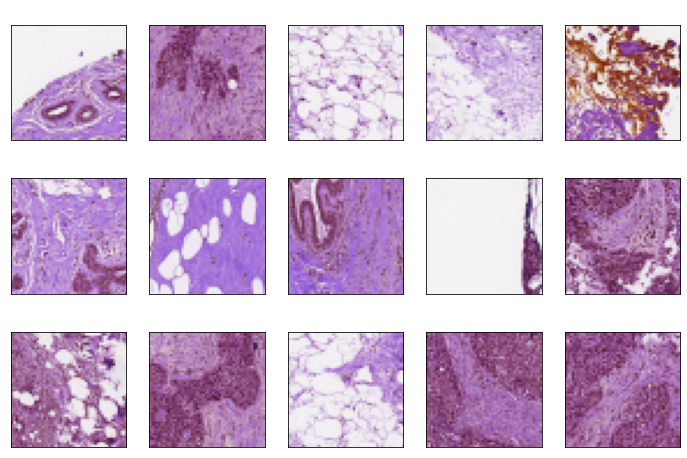

In [ ]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)


In [ ]:
print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (1028, 2)
test set shape: (61, 2)
validation set shape: (115, 2)


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 1028 validated image filenames belonging to 2 classes.
Found 115 validated image filenames belonging to 2 classes.
Found 61 validated image filenames belonging to 2 classes.


In [ ]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [ ]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)]
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])
history = model.fit(train_gen, validation_data = val_gen, epochs = 50, callbacks = [callbacks], verbose = 1)

Epoch 1/50
33/33 [==============================] - 175s 5s/step - loss: 0.7408 - accuracy: 0.5195 - val_loss: 0.6638 - val_accuracy: 0.5739
Epoch 2/50
33/33 [==============================] - 173s 5s/step - loss: 0.6929 - accuracy: 0.5720 - val_loss: 0.6606 - val_accuracy: 0.5826
Epoch 3/50
33/33 [==============================] - 171s 5s/step - loss: 0.6328 - accuracy: 0.6547 - val_loss: 0.5658 - val_accuracy: 0.7043
Epoch 4/50
33/33 [==============================] - 177s 5s/step - loss: 0.5944 - accuracy: 0.6955 - val_loss: 0.5203 - val_accuracy: 0.7913
Epoch 5/50
33/33 [==============================] - 176s 5s/step - loss: 0.5450 - accuracy: 0.7237 - val_loss: 0.5051 - val_accuracy: 0.8348
Epoch 6/50
33/33 [==============================] - 173s 5s/step - loss: 0.5292 - accuracy: 0.7558 - val_loss: 0.5118 - val_accuracy: 0.7913
Epoch 7/50
33/33 [==============================] - 174s 5s/step - loss: 0.4966 - accuracy: 0.7753 - val_loss: 0.4813 - val_accuracy: 0.7826
Epoch 8/50
33

In [ ]:
model.save("model.h5")

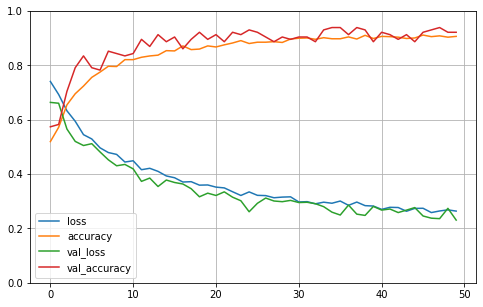

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
from PIL import Image
model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)
import numpy as np

image = cv2.imread("/content/breast-histopathology-images/10264/0/10264_idx5_x1001_y551_class0.png")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred >= 0.5:
  print("Yes")
else:
  print("No")

No


In [ ]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

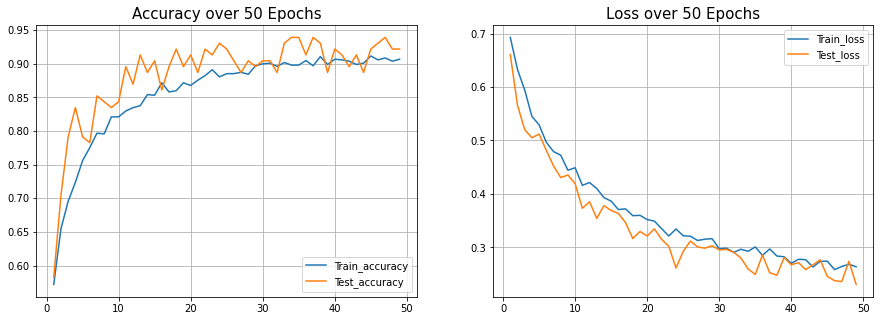

In [ ]:
import matplotlib.pyplot as plt
def plot_acc_loss(history, epochs):
 acc = history.history['accuracy']
 loss = history.history['loss']
 val_acc = history.history['val_accuracy']
 val_loss = history.history['val_loss']
 plt.figure(figsize=(15, 5))
 plt.subplot(121)
 plt.plot(range(1,epochs), acc[1:], label='Train_accuracy')
 plt.plot(range(1,epochs), val_acc[1:], label='Test_accuracy')
 plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
 plt.legend()
 plt.grid(True)
 plt.subplot(122)
 plt.plot(range(1,epochs), loss[1:], label='Train_loss')
 plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
 plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
 plt.legend()
 plt.grid(True)
 plt.show()
 
plot_acc_loss(history, 50)